# Reset circuitry

This paragraph deals with tracing signals of a synthesized result.
The background is, that a functional simulation (as from a MyHDL `@block` element) will not always tell the true story of what happens in hardware. In fact, it will hide a few things from you, as how a true reset sequence will look like in hardware.

Therefore, we will look at a waveform tracing approach to understand what is going on.
Again, we take a known example:

#### Simple XOR logic

In [1]:
from myhdl import *

@block
def sync_operation(clk, a, b, q):
    
    res = Signal(intbv(0x55)[8:])
    
    @always(clk.posedge)
    def worker():
        res.next = a ^ b
        
    @always_comb
    def assign():
        q.next = res

    return instances()


Synthesize the unit to logic: (you may also pay attention to the ResetSignal `arst` parameter).
Also note the `trace` parameter below. It will create a Verilog testbench - next to the unit under test - that includes a VCD wave trace.

In [2]:
from myhdl.conversion import yshelper as ys

arst = False # Sync reset
# Set the UNIT (to test) variable:
UNIT = sync_operation

# Declare the signals:    
clk = Signal(bool())
a, b, q = [ Signal(intbv()[8:]) for i in range(3) ]
reset = ResetSignal(0, 1, isasync = arst)

# Create an instance of the test unit for conversion:
entity = UNIT(clk, a, b, q)
name = entity.func.__name__
design = ys.Design(name)
# Convert into synthesis RTLIL:
# Make sure to set `trace` when you wish to look at a VCD file:
entity.convert("yosys_module", design, name=name, trace=True)

# Write out the verilog post-synthesis code for the cosimulation object (further below)
design.write_verilog(design.name, True)

CREATE Module: 'sync_operation'
Adding module with name: sync_operation_1_8_8_8
CONVERT_RTL tree >>>>>> 'SYNC_OPERATION_WORKER' 
CONVERT_RTL tree >>>>>> 'SYNC_OPERATION_ASSIGN' 
DONE instancing submodules


Display the generated verilog module:

In [3]:
!cat sync_operation_mapped.v

/* Generated by Yosys 0.9+2406 (git sha1 b822beb1, gcc 8.3.0-6 -Og -fPIC) */

(* top =  1  *)
module sync_operation(clk, a, b, q);
  wire [7:0] _0_;
  reg [7:0] _1_;
  input [7:0] a;
  input [7:0] b;
  input clk;
  output [7:0] q;
  wire [7:0] \res::wire ;
  wire \reset::wire ;
  assign _0_ = a ^ b;
  always @(posedge clk)
      _1_ <= _0_;
  assign \res::wire  = _1_;
  assign q = \res::wire ;
endmodule


Yoy might also look at the generated test bench:

In [4]:
!cat tb_sync_operation_mapped.v

// MyHDL generated test bench, may be overwritten

// Using explicit timescale spec for co-simulation
`timescale 1ps/1ps
module tb_sync_operation;

reg clk;
reg [7:0] a;
reg [7:0] b;
wire [7:0] q;

initial begin
    $dumpfile("sync_operation.vcd");
    $dumpvars(0, dut);
    $from_myhdl(
        clk,
        a,
        b
    );
    $to_myhdl(
        q
    );
end

sync_operation dut(
    .clk(clk),
    .a(a),
    .b(b),
    .q(q)
);

endmodule


Now we create a simple Cosimulation object for this test bench:

In [5]:
# Create cosimulation object:

from ys_aux import setupCosimulation

@block
def mapped_uut(which, clk, a, b, q):
    args = locals()
    name = which.func.__name__ + "_mapped"
    del args['which']

    return setupCosimulation(name, False, args)

Then we run both the MyHDL unit and Cosimulation object in parallel:

In [6]:
# Test bench:

from ys_aux import clkgen

@block
def testbench(uut, uut_syn, arst):
    # Declare the signals:    
    clk = Signal(bool())
    a, b, q0, q1 = [ Signal(intbv()[8:]) for i in range(4) ]
    reset = ResetSignal(0, 1, isasync = arst)
    
    # Clock generator
    inst_clkgen = clkgen(clk, 1)
    # Instance of myhdl unit:
    inst_uut = uut(clk, a, b, q0)           # Output is q0
    inst_syn = uut_syn(uut, clk, a, b, q1)  # Output is q1

    VALUES = [ 0xaa, 0xab, 0x00, 0x00, 0x00 ]
    
    @instance
    def stimulus():
        a.next = 0xaa
        print("a  b  q0 q1")
        for v in VALUES:
            yield clk.posedge
            print(a, b, q0, q1)
            yield clk.negedge
            b.next = v
            
    
    return instances()


Finally, we execute the simulation. After that, a VCD will be output. The `trace` argument below applies to the tracing of the MyHDL object simulation (not the Cosimulation objects).

In [7]:
# Run the cosimulation:
tb = testbench(UNIT, mapped_uut, arst)

tb.config_sim(backend = 'myhdl', timescale="1ps", trace=True)
tb.run_sim(15)
tb.quit_sim() # Quit so we can run another one

a  b  q0 q1
aa 00 55 00
aa aa aa aa
aa ab 00 00
aa 00 01 01
aa 00 aa aa


<class 'myhdl._SuspendSimulation'>: Simulated 15 timesteps


A VCD file should have been created when `trace=True`:

In [8]:
!ls -l sync_operation.vcd

-rw-r--r-- 1 pyosys users 792 Mar 21 21:46 sync_operation.vcd


#### Trace of synchronous reset

In [9]:
import wavedraw
import nbwavedrom

TB = "tb_sync_operation.dut"

# Configure waveform:
cfg = { TB + '.reset' : None, TB + '.a[7:0]' : None, TB + '.b[7:0]' : None, TB + '.q[7:0]' : None}

waveform = wavedraw.vcd2wave("sync_operation.vcd", TB + '.clk', cfg)
    
nbwavedrom.draw(waveform)

## Exercises

1. Enhance the `sync_operation` module by the already provided reset signal (which is not yet wired). Make sure A and B are initialized to all bits set.
+  Create a synthesis RTL diagram from it. Explain behaviour.
+  Change the reset signal behaviour from synchronous to asychronous and create a setup
   which demonstrates the differences of the reset situation. Also create an RTL diagram.

**Hint**: Modify the above code such that you can reuse most of the functionality. Only copy&paste where necessary, keep the code snippets as short as possible.
   
First, make a copy of this file **File > Make a Copy...**, save with name `trace-exercise.ipynb`.
To commit, uncomment the following commands on the bottom and run them.

### 1. Reset enhancement

You may modify the [above example](#Simple-XOR-logic) 'inline'.


### 2.  RTL diagram

Generating RTL image...
Display...


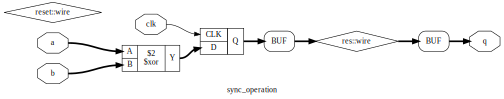

In [10]:
from ys_aux import to_svg
svg = to_svg(design, "", 75)
display(svg)

#### Comment

... fill in ...

### 3. Asynchronous Reset

#### Comment

... fill in ...

### RTL image of asynchronous reset

In [11]:
# from ys_aux import to_svg

# display(to_svg(async_design, "", 80))

In [12]:
# ! git add trace-exercise.ipynb

In [13]:
# ! git commit -m "Added trace exercise"